<a href="https://colab.research.google.com/github/nisaakan/DSA210-Project/blob/main/DSA210_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DSA210 Project - Mental Health & Technology Usage Project

Data Collection

*   In this project, the dataset "Mental Health and Technology Usage 2024" was uploaded locally as a .csv file. It was loaded using Python’s pandas library to prepare it for analysis, including cleaning,
visualization, and modeling.
*   Source: Kaggle(https://www.kaggle.com/datasets/waqi786/mental-health-and-technology-usage-dataset)







In [1]:
# File upload (Google Colab)
from google.colab import files
uploaded = files.upload()

Saving mental_health_and_technology_usage_2024.csv to mental_health_and_technology_usage_2024 (5).csv


In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [3]:
# Load CSV file
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

# Data Overview
print("First 5 rows of the dataset:")
display(data.head())
print("\nDataset Info:")
data.info()
print("\nDescriptive Statistics:")
display(data.describe())

# Standardize column names (optional, improves consistency)
data.columns = data.columns.str.strip().str.replace(' ', '_')

# Remove duplicate rows
initial_shape = data.shape
data.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_shape[0] - data.shape[0]}")

# Convert 'Age' to numeric if needed
if 'Age' in data.columns:
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

# Remove impossible or negative values (e.g., negative hours)
num_cols = ['Technology_Usage_Hours', 'Social_Media_Usage_Hours', 'Gaming_Hours',
            'Screen_Time_Hours', 'Sleep_Hours', 'Physical_Activity_Hours', 'Age']
for col in num_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # ensure numeric
        data[col] = data[col].apply(lambda x: np.nan if x is not None and x < 0 else x)

# Missing Value Handling
print("\nMissing value count:")
print(data.isnull().sum())

for col in data.columns:
    if data[col].dtype == 'object':
        if data[col].isnull().any():
            mode_val = data[col].mode()
            if not mode_val.empty:
                data[col].fillna(mode_val[0], inplace=True)
    else:
        if data[col].isnull().any():
            data[col].fillna(data[col].mean(), inplace=True)

# Outlier Handling using IQR method
def cap_outliers(col):
    if col in data.columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        data[col] = np.where(data[col] < lower, lower,
                             np.where(data[col] > upper, upper, data[col]))

numeric_cols_to_check = ['Screen_Time_Hours', 'Sleep_Hours', 'Technology_Usage_Hours',
                         'Social_Media_Usage_Hours', 'Gaming_Hours', 'Physical_Activity_Hours']
for col in numeric_cols_to_check:
    cap_outliers(col)

# Normalize numeric features before modeling
numeric_cols = ['Technology_Usage_Hours', 'Social_Media_Usage_Hours', 'Gaming_Hours',
                'Screen_Time_Hours', 'Sleep_Hours', 'Physical_Activity_Hours', 'Age']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


First 5 rows of the dataset:


,User_ID,Age,Gender,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Mental_Health_Status,Stress_Level,Sleep_Hours,Physical_Activity_Hours,Support_Systems_Access,Work_Environment_Impact,Online_Support_Usage
0,USER-00001,23,Female,6.57,6.00,0.68,12.36,Good,Low,8.01,6.71,No,Negative,Yes
1,USER-00002,21,Male,3.01,2.57,3.74,7.61,Poor,High,7.28,5.88,Yes,Positive,No
2,USER-00003,51,Male,3.04,6.14,1.26,3.16,Fair,High,8.04,9.81,No,Negative,No
3,USER-00004,25,Female,3.84,4.48,2.59,13.08,Excellent,Medium,5.62,5.28,Yes,Negative,Yes
4,USER-00005,53,Male,1.20,0.56,0.29,12.63,Good,Low,5.55,4.00,No,Positive,Yes



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User_ID                   10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Gender                    10000 non-null  object 
 3   Technology_Usage_Hours    10000 non-null  float64
 4   Social_Media_Usage_Hours  10000 non-null  float64
 5   Gaming_Hours              10000 non-null  float64
 6   Screen_Time_Hours         10000 non-null  float64
 7   Mental_Health_Status      10000 non-null  object 
 8   Stress_Level              10000 non-null  object 
 9   Sleep_Hours               10000 non-null  float64
 10  Physical_Activity_Hours   10000 non-null  float64
 11  Support_Systems_Access    10000 non-null  object 
 12  Work_Environment_Impact   10000 non-null  object 
 13  Online_Support_Usage      10000 non-null  objec

,Age,Technology_Usage_Hours,Social_Media_Usage_Hours,Gaming_Hours,Screen_Time_Hours,Sleep_Hours,Physical_Activity_Hours
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,41.518600,6.474341,3.972321,2.515598,7.975765,6.500724,5.003860
std,13.920217,3.169022,2.313707,1.446748,4.042608,1.450933,2.905044
min,18.000000,1.000000,0.000000,0.000000,1.000000,4.000000,0.000000
25%,29.000000,3.760000,1.980000,1.260000,4.520000,5.260000,2.490000
50%,42.000000,6.425000,3.950000,2.520000,7.900000,6.500000,4.990000
75%,54.000000,9.212500,5.990000,3.790000,11.500000,7.760000,7.540000
max,65.000000,12.000000,8.000000,5.000000,15.000000,9.000000,10.000000


Duplicates removed: 0

Missing value count:
User_ID                     0
Age                         0
Gender                      0
Technology_Usage_Hours      0
Social_Media_Usage_Hours    0
Gaming_Hours                0
Screen_Time_Hours           0
Mental_Health_Status        0
Stress_Level                0
Sleep_Hours                 0
Physical_Activity_Hours     0
Support_Systems_Access      0
Work_Environment_Impact     0
Online_Support_Usage        0
dtype: int64


In [4]:
## Feature Engineering

# Numeric stress level
stress_map = {'Low': 1, 'Medium': 2, 'High': 3}
data['Stress_Level_Numeric'] = data['Stress_Level'].map(stress_map)

# Average tech + screen time
data['Avg_Tech_Screen'] = (data['Technology_Usage_Hours'] + data['Screen_Time_Hours']) / 2

# Binary flag: High stress = 1 if stress level is high
data['High_Stress'] = data['Stress_Level_Numeric'].apply(lambda x: 1 if x == 3 else 0)

# Screen time bucket
def bucket_screen_time(x):
    if x < 2:
        return 'Low'
    elif x <= 6:
        return 'Medium'
    else:
        return 'High'

data['ScreenTime_Level'] = data['Screen_Time_Hours'].apply(bucket_screen_time)

# Ratio feature
data['ScreenTime_to_Sleep'] = data['Screen_Time_Hours'] / (data['Sleep_Hours'] + 1e-5)


In [5]:
# Dummy variables
if 'Gender' in data.columns:
    gender_encoded = pd.get_dummies(data['Gender'], prefix='Gender')
    data = pd.concat([data, gender_encoded], axis=1)
else:
    print("Column 'Gender' not found.")

if 'Mental_Health_Status' in data.columns:
    mental_encoded = pd.get_dummies(data['Mental_Health_Status'], prefix='Mental')
    data = pd.concat([data, mental_encoded], axis=1)
else:
    print("Column 'Mental_Health_Status' not found.")

if 'Support_Systems_Access' in data.columns:
    support_encoded = pd.get_dummies(data['Support_Systems_Access'], prefix='Support')
    data = pd.concat([data, support_encoded], axis=1)
else:
    print("Column 'Support_Systems_Access' not found.")

if 'Work_Environment_Impact' in data.columns:
    work_encoded = pd.get_dummies(data['Work_Environment_Impact'], prefix='Work')
    data = pd.concat([data, work_encoded], axis=1)
else:
    print("Column 'Work_Environment_Impact' not found.")

if 'Online_Support_Usage' in data.columns:
    online_encoded = pd.get_dummies(data['Online_Support_Usage'], prefix='Online')
    data = pd.concat([data, online_encoded], axis=1)
else:
    print("Column 'Online_Support_Usage' not found.")


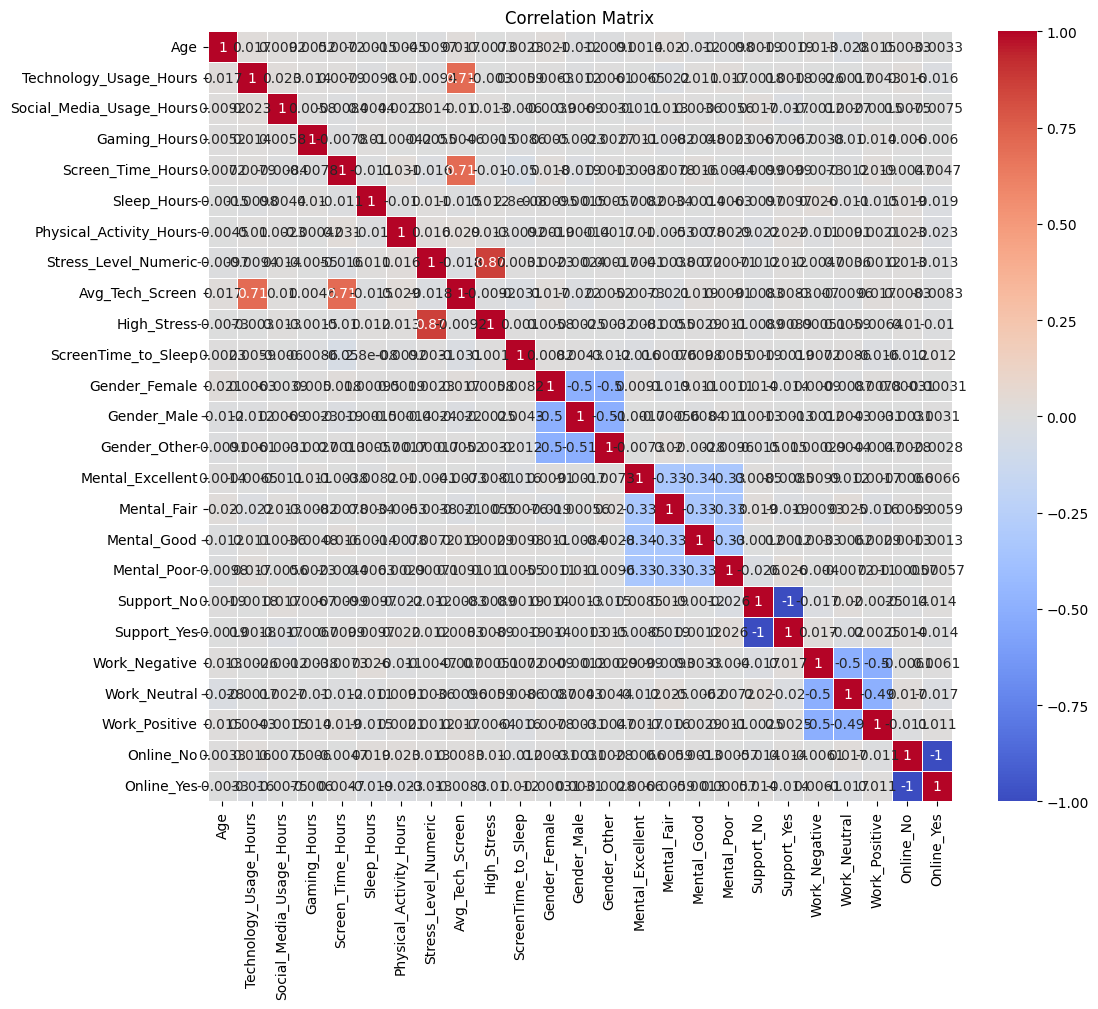

In [6]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


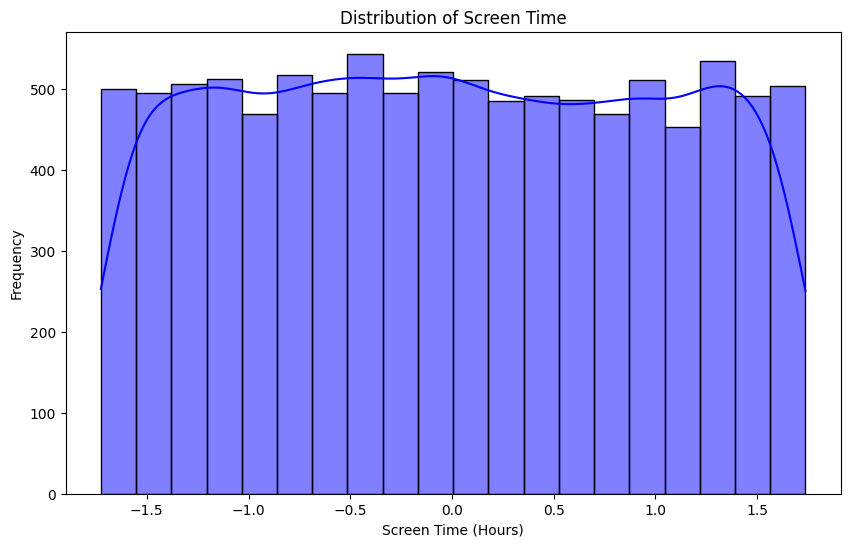

Screen Time Statistics:
Mean: 0.00 hrs
Median: -0.02 hrs
Mode: 0.94 hrs


<ipython-input-7-90ff9f0900e3>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Mental_Health_Status', data=data, palette='pastel')


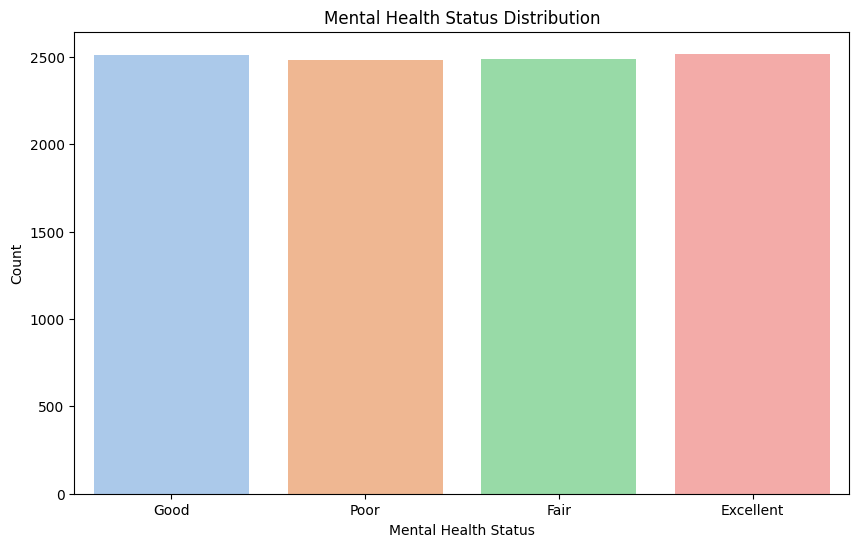

<ipython-input-7-90ff9f0900e3>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stress_Level', data=data, palette='muted')


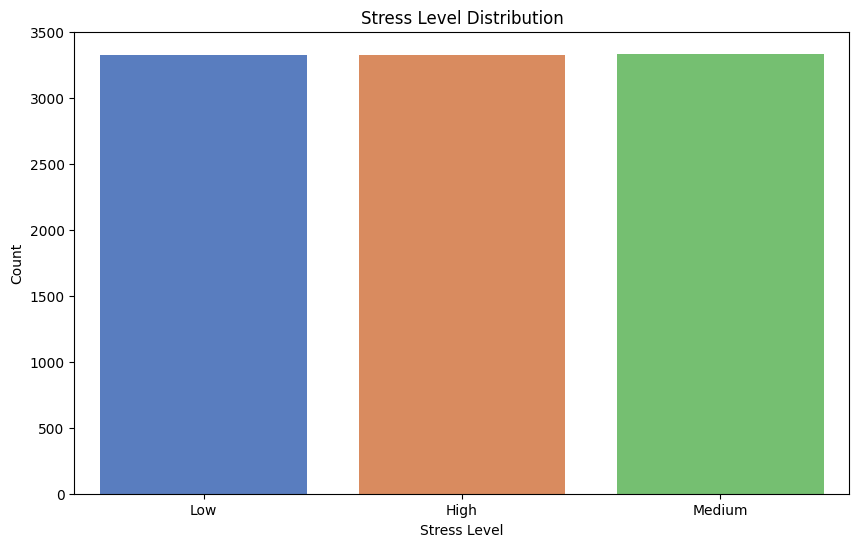

In [7]:
## Univariate Analysis

# Histogram of Screen Time
plt.figure(figsize=(10, 6))
sns.histplot(data['Screen_Time_Hours'], kde=True, bins=20, color='blue')
plt.title("Distribution of Screen Time")
plt.xlabel("Screen Time (Hours)")
plt.ylabel("Frequency")
plt.show()

# Summary statistics
print("Screen Time Statistics:")
print(f"Mean: {data['Screen_Time_Hours'].mean():.2f} hrs")
print(f"Median: {data['Screen_Time_Hours'].median():.2f} hrs")
print(f"Mode: {data['Screen_Time_Hours'].mode()[0]:.2f} hrs")

# Count plot for Mental Health Status
plt.figure(figsize=(10, 6))
sns.countplot(x='Mental_Health_Status', data=data, palette='pastel')
plt.title("Mental Health Status Distribution")
plt.xlabel("Mental Health Status")
plt.ylabel("Count")
plt.show()

# Count plot for Stress Level
plt.figure(figsize=(10, 6))
sns.countplot(x='Stress_Level', data=data, palette='muted')
plt.title("Stress Level Distribution")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()


<ipython-input-8-1cd167007cc0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stress_Level', y='Screen_Time_Hours', data=data, palette='Set2')


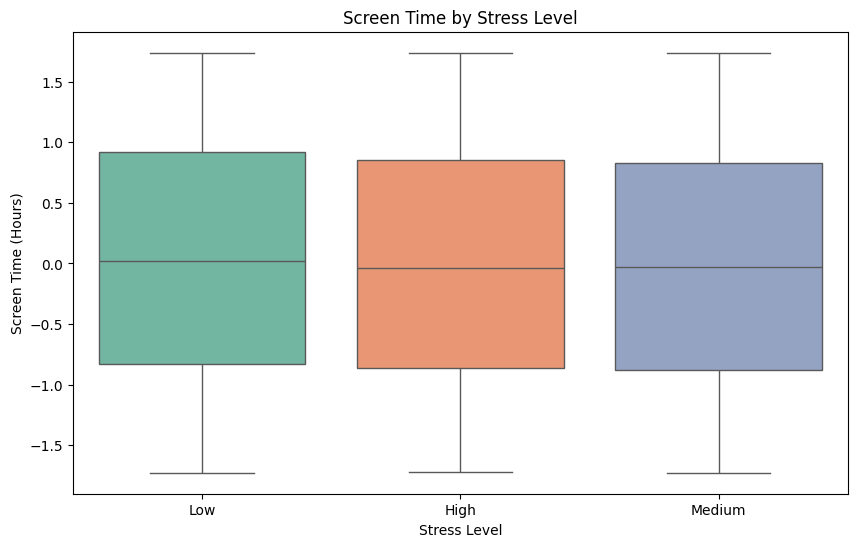

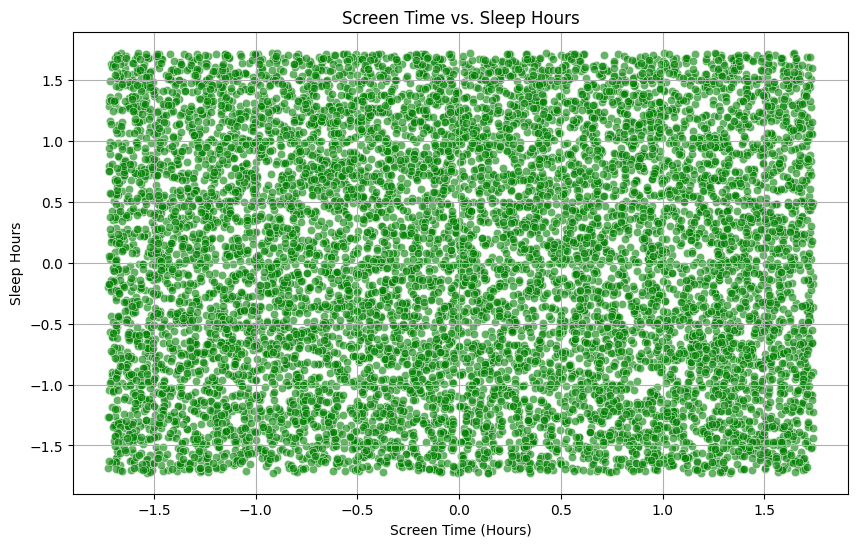

<ipython-input-8-1cd167007cc0>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stress_Level', y='Physical_Activity_Hours', data=data, palette='coolwarm')


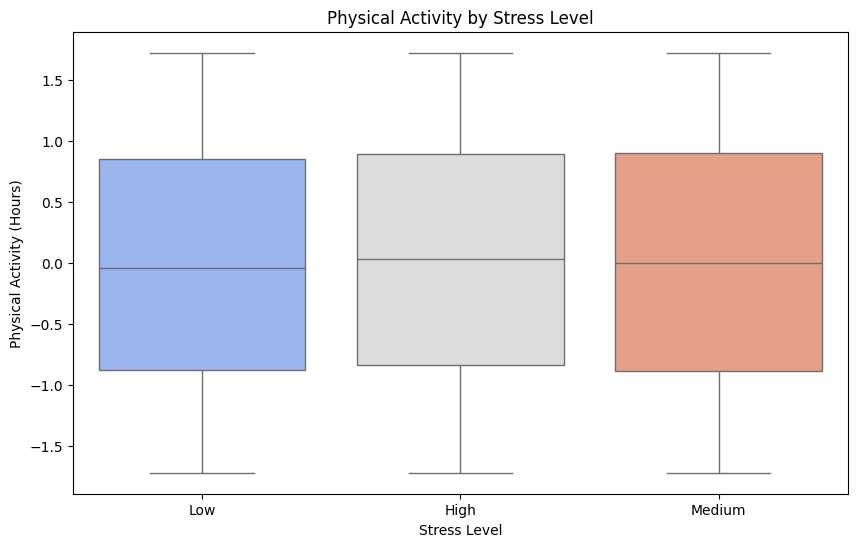

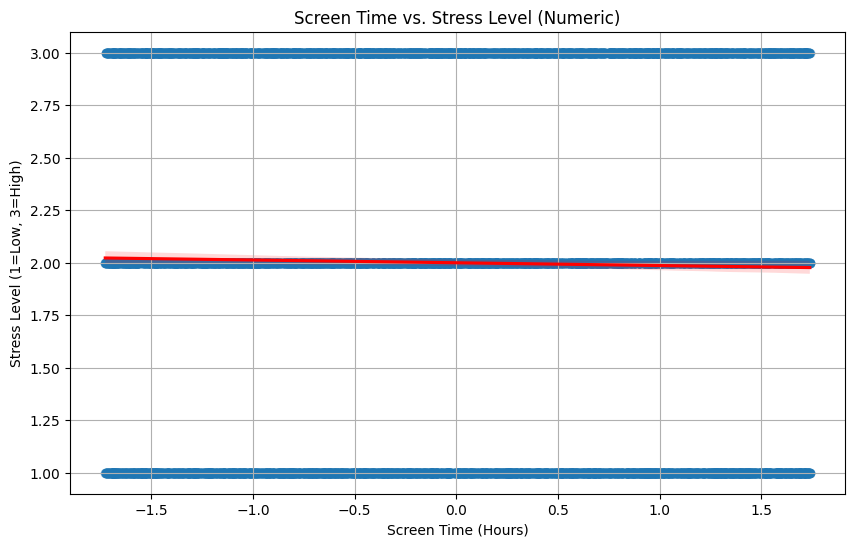

<ipython-input-8-1cd167007cc0>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='ScreenTime_Level', y='Sleep_Hours', data=data, palette='pastel')


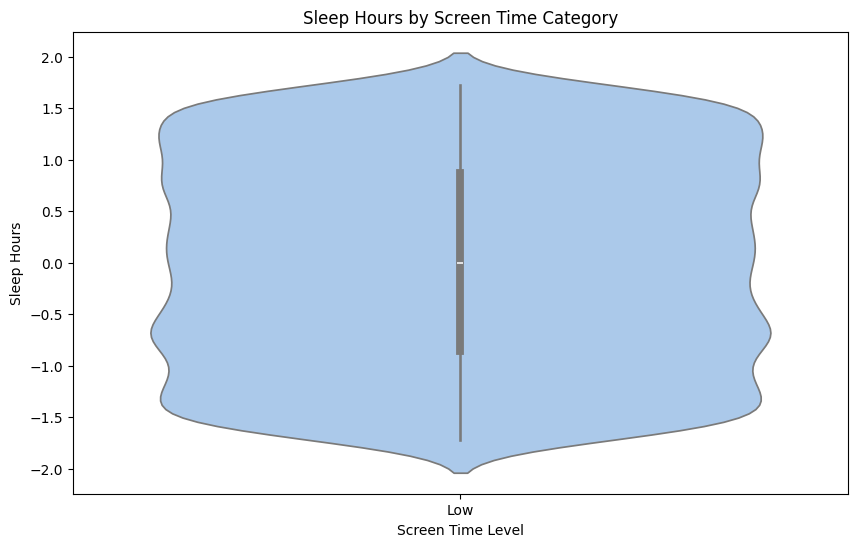

In [8]:
## Bivariate Analysis

# Boxplot: Screen Time by Stress Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Level', y='Screen_Time_Hours', data=data, palette='Set2')
plt.title("Screen Time by Stress Level")
plt.xlabel("Stress Level")
plt.ylabel("Screen Time (Hours)")
plt.show()

# Scatterplot: Screen Time vs. Sleep Hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Screen_Time_Hours', y='Sleep_Hours', data=data, alpha=0.6, color='green')
plt.title("Screen Time vs. Sleep Hours")
plt.xlabel("Screen Time (Hours)")
plt.ylabel("Sleep Hours")
plt.grid(True)
plt.show()

# Boxplot: Physical Activity by Stress Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stress_Level', y='Physical_Activity_Hours', data=data, palette='coolwarm')
plt.title("Physical Activity by Stress Level")
plt.xlabel("Stress Level")
plt.ylabel("Physical Activity (Hours)")
plt.show()

# Scatterplot with trendline
plt.figure(figsize=(10, 6))
sns.regplot(x='Screen_Time_Hours', y='Stress_Level_Numeric', data=data,
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title("Screen Time vs. Stress Level (Numeric)")
plt.xlabel("Screen Time (Hours)")
plt.ylabel("Stress Level (1=Low, 3=High)")
plt.grid(True)
plt.show()

# Violin plot: Sleep Hours by Screen Time Level
plt.figure(figsize=(10, 6))
sns.violinplot(x='ScreenTime_Level', y='Sleep_Hours', data=data, palette='pastel')
plt.title("Sleep Hours by Screen Time Category")
plt.xlabel("Screen Time Level")
plt.ylabel("Sleep Hours")
plt.show()


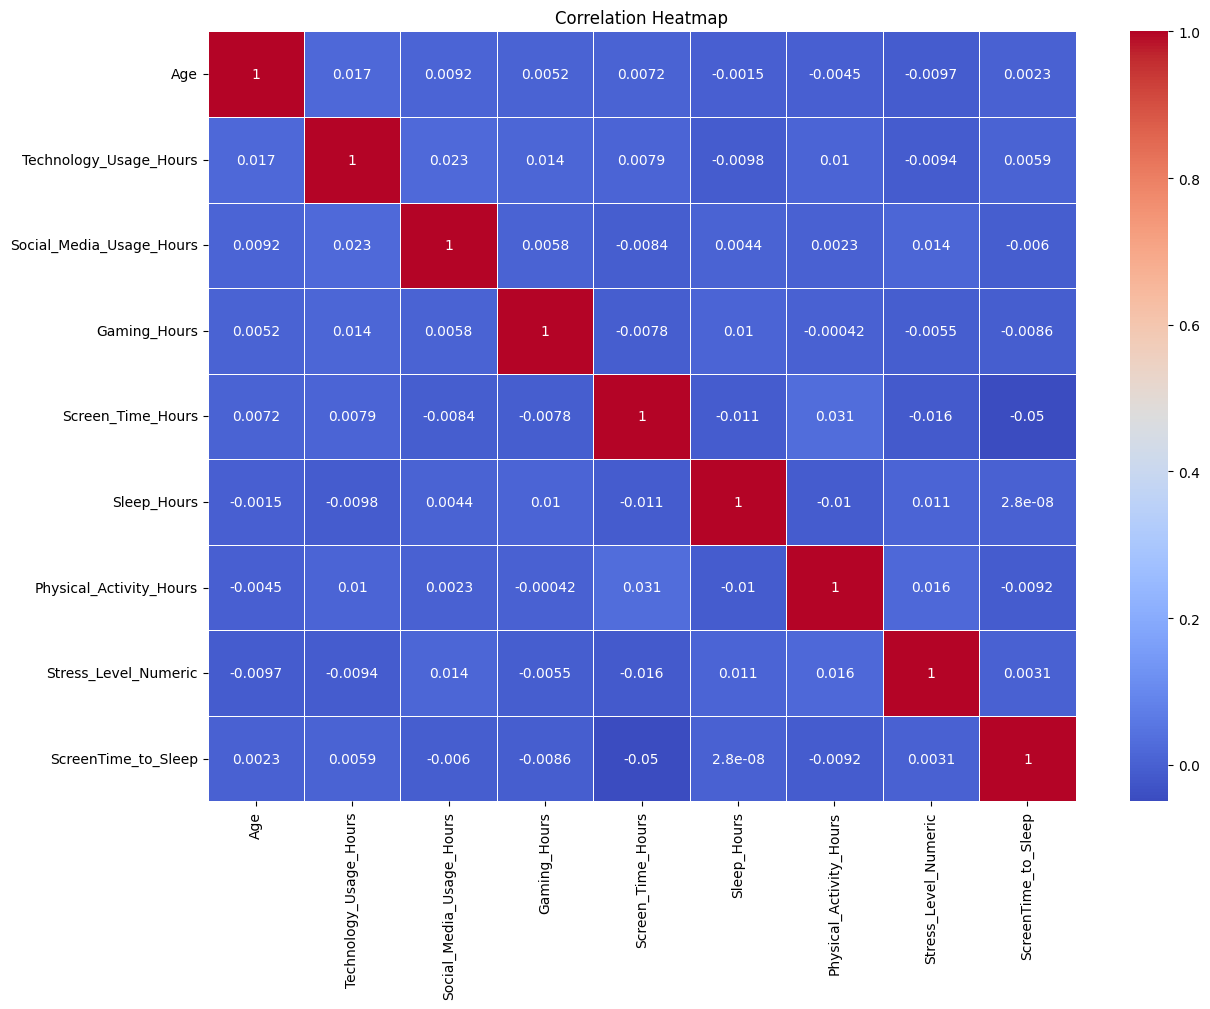

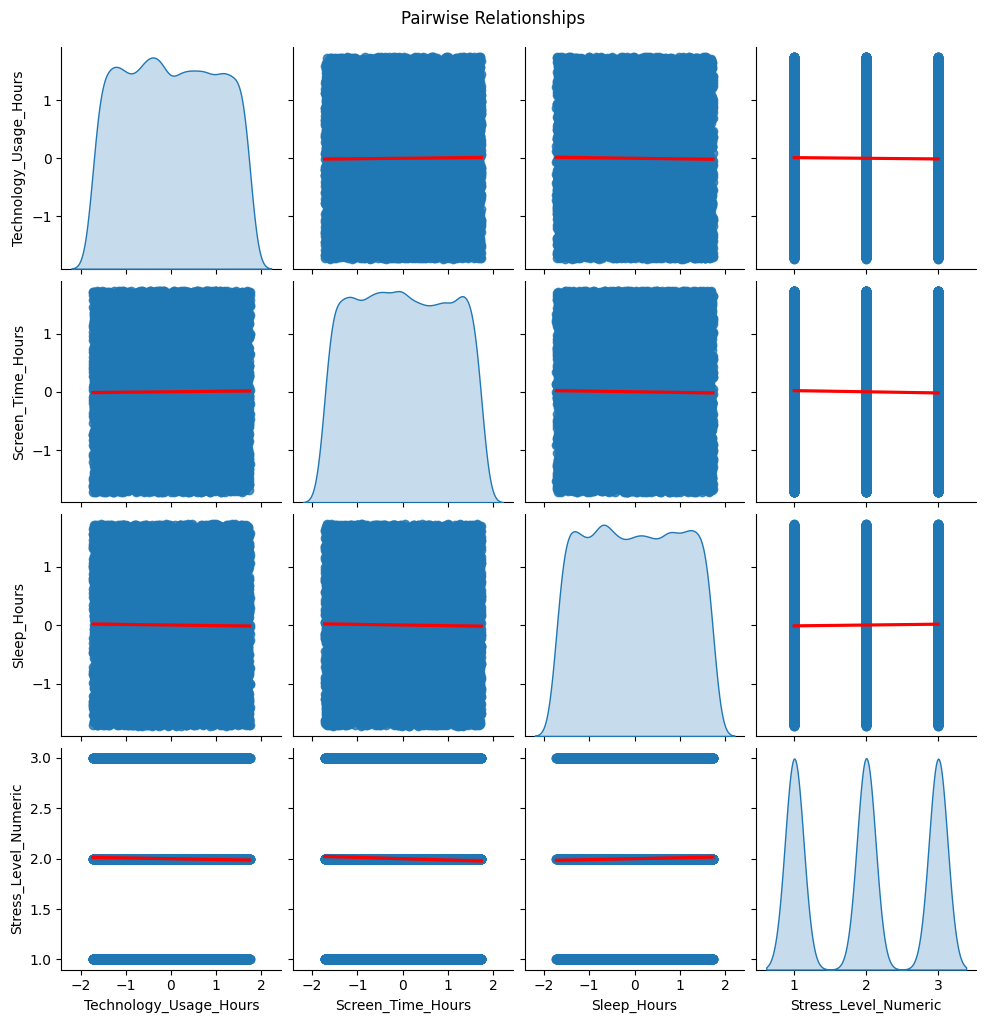

In [9]:
## Multivariate Analysis

# Select relevant numeric columns for correlation
corr_cols = [
    'Age', 'Technology_Usage_Hours', 'Social_Media_Usage_Hours', 'Gaming_Hours',
    'Screen_Time_Hours', 'Sleep_Hours', 'Physical_Activity_Hours',
    'Stress_Level_Numeric', 'ScreenTime_to_Sleep'
]

# Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data[corr_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Pairplot with regression lines
sns.pairplot(
    data[['Technology_Usage_Hours', 'Screen_Time_Hours', 'Sleep_Hours', 'Stress_Level_Numeric']],
    diag_kind='kde',
    kind='reg',
    plot_kws={'line_kws': {'color': 'red'}}
)
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


In [10]:
# Statistical Analysis (OLS Regression)
X_ols = sm.add_constant(data['Screen_Time_Hours'])
y_ols = data['Sleep_Hours']
model = sm.OLS(y_ols, X_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Sleep_Hours   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.250
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.264
Time:                        17:05:07   Log-Likelihood:                -14189.
No. Observations:               10000   AIC:                         2.838e+04
Df Residuals:                    9998   BIC:                         2.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6.427e-16      0.01

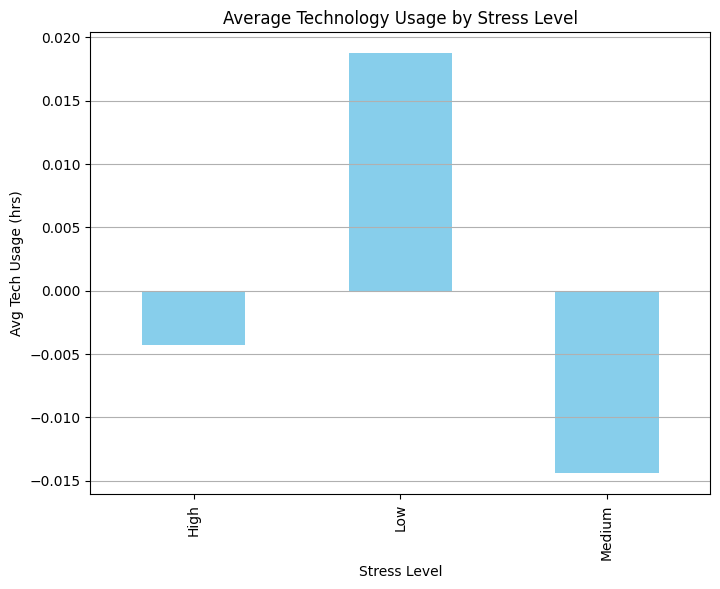

In [11]:
# Grouped Analysis
stress_usage = data.groupby('Stress_Level')['Technology_Usage_Hours'].mean()
plt.figure(figsize=(8, 6))
stress_usage.plot(kind='bar', color='skyblue')
plt.title('Average Technology Usage by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Avg Tech Usage (hrs)')
plt.grid(axis='y')
plt.show()

Linear Regression:
 - MSE: 0.68
 - R²: -0.00


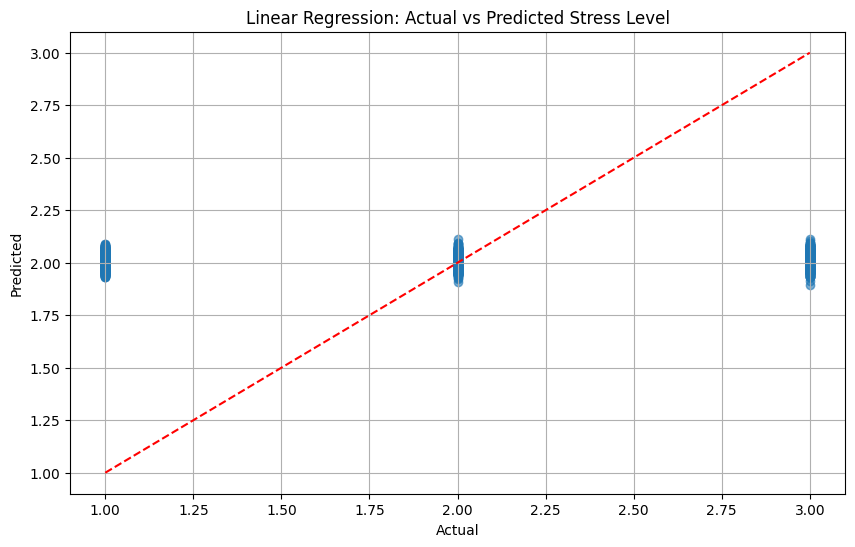

Decision Tree:
 - MSE: 1.28
 - R²: -0.90


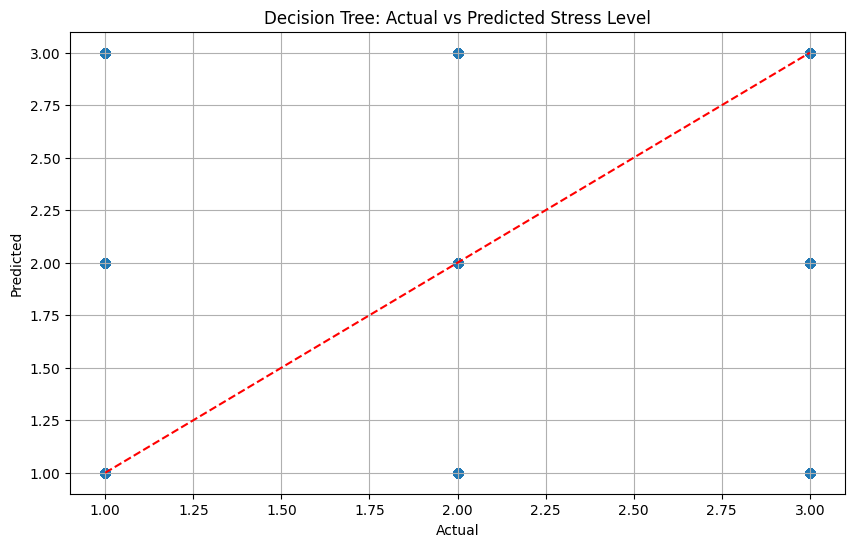

Random Forest:
 - MSE: 0.69
 - R²: -0.03


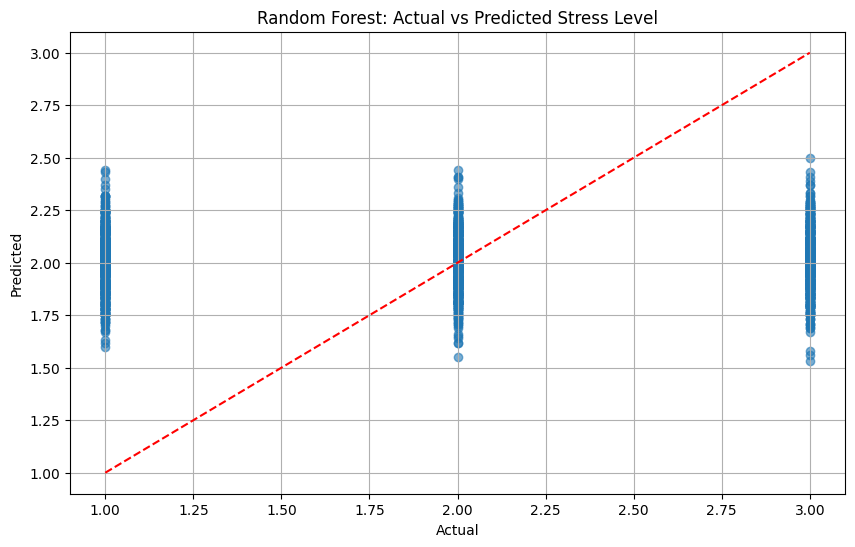


Best Model: Linear Regression (R² = -0.00)

Pearson Correlation: -0.01
P-Value: 0.2636
No statistically significant relationship.


In [12]:
# Features list
X_columns = ['Technology_Usage_Hours', 'Social_Media_Usage_Hours', 'Gaming_Hours',
             'Screen_Time_Hours', 'Sleep_Hours', 'Physical_Activity_Hours', 'Age']

# Add encoded dummy variable columns only if they exist
if 'gender_encoded' in locals():
    X_columns += list(gender_encoded.columns)
if 'mental_encoded' in locals():
    X_columns += list(mental_encoded.columns)
if 'support_encoded' in locals():
    X_columns += list(support_encoded.columns)
if 'work_encoded' in locals():
    X_columns += list(work_encoded.columns)
if 'online_encoded' in locals():
    X_columns += list(online_encoded.columns)

# Define features and target
X = data[X_columns]
y = data['Stress_Level_Numeric']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}

    print(f"{name}:\n - MSE: {mse:.2f}\n - R²: {r2:.2f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f"{name}: Actual vs Predicted Stress Level")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.show()

# Identify the best model based on R²
best_model = max(results, key=lambda x: results[x]['R²'])
print(f"\nBest Model: {best_model} (R² = {results[best_model]['R²']:.2f})")

# Pearson Correlation
corr, p_val = pearsonr(data['Screen_Time_Hours'], data['Sleep_Hours'])
print(f"\nPearson Correlation: {corr:.2f}")
print(f"P-Value: {p_val:.4f}")
if p_val < 0.05:
    print("Statistically significant relationship.")
else:
    print("No statistically significant relationship.")


In [13]:
# Hypothesis Testing Explanation and Correlation Test
print("\n--- Hypothesis Testing Explanation ---")
print("Null Hypothesis (H0): There is no correlation between screen time and sleep hours.")
print("Alternative Hypothesis (H1): There is a correlation between screen time and sleep hours.")
corr_coef, p_val = pearsonr(data['Screen_Time_Hours'], data['Stress_Level_Numeric'])
print(f"Pearson Correlation Coefficient: {corr_coef:.2f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("The p-value is less than 0.05. We reject the null hypothesis.")
else:
    print("The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.")



--- Hypothesis Testing Explanation ---
Null Hypothesis (H0): There is no correlation between screen time and sleep hours.
Alternative Hypothesis (H1): There is a correlation between screen time and sleep hours.
Pearson Correlation Coefficient: -0.02
P-Value: 0.1063
The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.


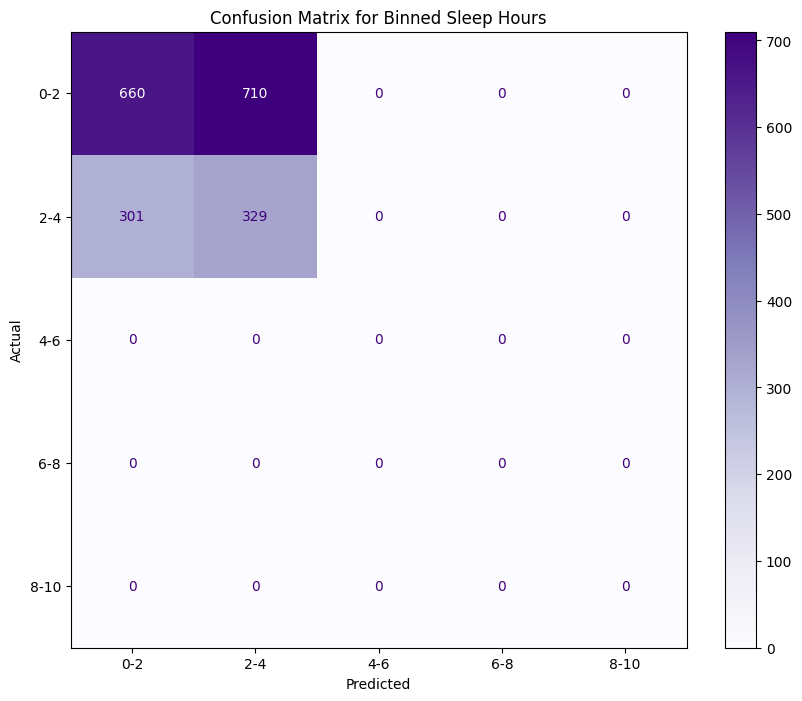

In [14]:
# Classification - Confusion Matrix
bins = [0, 2, 4, 6, 8, 10]
labels = ['0-2', '2-4', '4-6', '6-8', '8-10']
y_test_clipped = pd.cut(y_test, bins=bins, labels=labels)
y_pred_clipped = pd.cut(y_pred, bins=bins, labels=labels)

# Convert to numeric
y_test_bins_numeric = pd.Categorical(y_test_clipped).codes
y_pred_bins_numeric = pd.Categorical(y_pred_clipped).codes

# Confusion matrix
conf_mat = confusion_matrix(y_test_bins_numeric, y_pred_bins_numeric, labels=range(len(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Purples', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix for Binned Sleep Hours")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()